In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [24]:
df = yf.download("BTC-USD")

[*********************100%***********************]  1 of 1 completed


In [25]:
sequence = df['Adj Close'].to_frame()

In [26]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
scaled= sc.fit_transform(sequence)
scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.34940068],
       [0.34566269],
       [0.34693275]])

In [27]:
sequence= scaled
sequence

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.34940068],
       [0.34566269],
       [0.34693275]])

In [28]:
n = len(sequence)
train_ratio = 0.8
train = sequence[:int(train_ratio * n)]
test = sequence[int(train_ratio * n):]

In [29]:
timestep = 10
x_train, y_train = [], []
for i in range(timestep, len(train)):
    x_train.append(train[i - timestep:i])
    y_train.append(train[i])

x_test, y_test = [], []
for i in range(timestep, len(test)):
    x_test.append(test[i - timestep:i])
    y_test.append(test[i])

In [30]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [32]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
model =Sequential()
model.add(LSTM(units=100, input_shape=(timestep, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
77/77 [==============================] - 2s 5ms/step - loss: 0.0030
Epoch 2/100
77/77 [==============================] - 0s 5ms/step - loss: 3.6832e-04
Epoch 3/100
77/77 [==============================] - 0s 5ms/step - loss: 3.6273e-04
Epoch 4/100
77/77 [==============================] - 0s 5ms/step - loss: 3.7047e-04
Epoch 5/100
77/77 [==============================] - 0s 5ms/step - loss: 3.4229e-04
Epoch 6/100
77/77 [==============================] - 0s 5ms/step - loss: 2.7924e-04
Epoch 7/100
77/77 [==============================] - 0s 5ms/step - loss: 3.4413e-04
Epoch 8/100
77/77 [==============================] - 0s 5ms/step - loss: 2.7749e-04
Epoch 9/100
77/77 [==============================] - 0s 5ms/step - loss: 2.4305e-04
Epoch 10/100
77/77 [==============================] - 0s 5ms/step - loss: 2.9129e-04
Epoch 11/100
77/77 [==============================] - 0s 6ms/step - loss: 1.9604e-04
Epoch 12/100
77/77 [==============================] - 0s 5ms/step - loss: 2.21

In [34]:
y_train= sc.inverse_transform(y_train)
y_pred_train = model.predict(x_train)
y_pred_train= sc.inverse_transform(y_pred_train)
y_test= sc.inverse_transform(y_test)
y_pred_test = model.predict(x_test)
y_pred_test=sc.inverse_transform(y_pred_test)

19/19 [==============================] - 0s 2ms/step


In [35]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

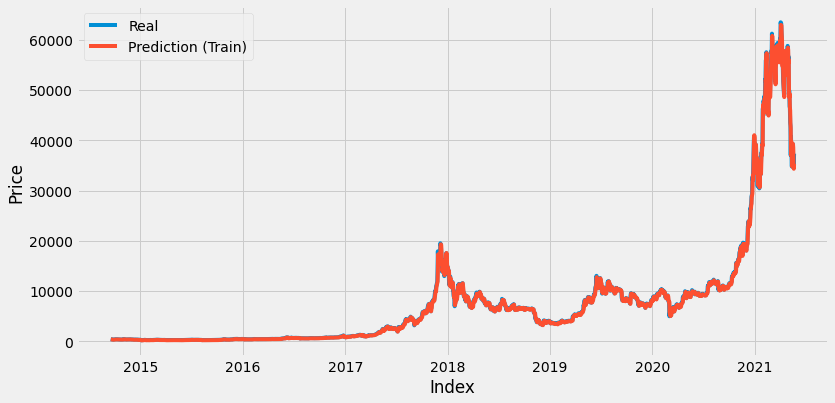

In [36]:
plt.figure(figsize=(12,6))
plt.plot(df.index[:len(y_train)], y_train, label='Real')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

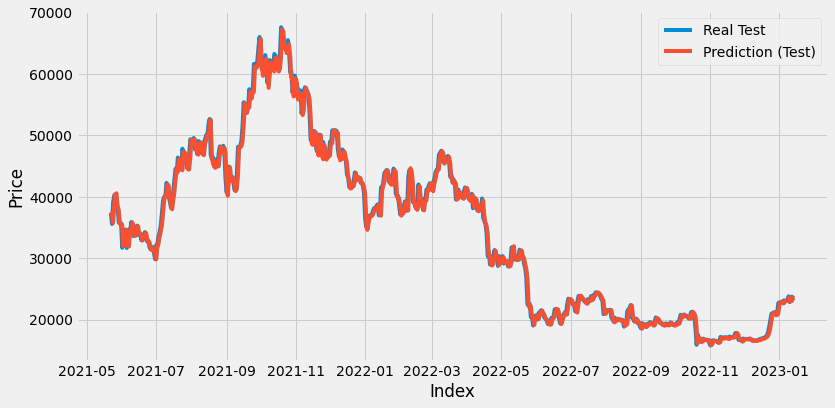

In [37]:
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.figure(figsize=(12,6))
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

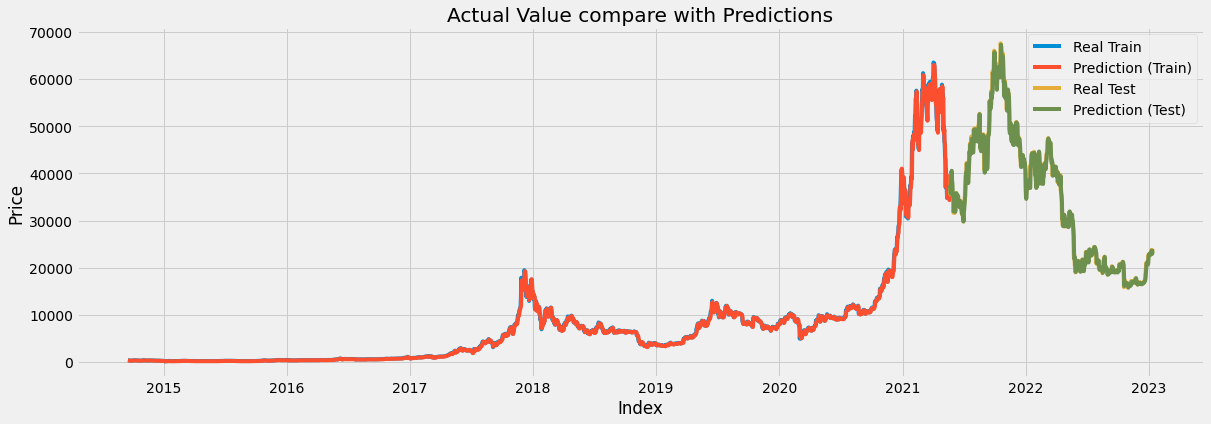

In [38]:
plt.figure(figsize=(18,6))
plt.plot(df.index[:len(y_train)], y_train, label='Real Train')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.title('Actual Value compare with Predictions')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse= mean_squared_error(y_pred_test, y_test)
rmse=sqrt(mse)
print('MSE LSTM: %.2f' % mse)
print('RMSE LSTM: %.2f' % rmse)

MSE LSTM: 1662396.11
RMSE LSTM: 1289.34


In [40]:
# Tính toán dữ liệu đầu vào cho 6 tháng tiếp theo
from datetime import timedelta
last_6month = y_test[-180:]
input_data = []
for i in range(len(last_6month) - timestep):
    input_data.append(last_6month[i:i + timestep])
input_data = np.array(input_data).reshape(-1, timestep, 1)

# Dự đoán giá trị 6 tháng tiếp theo
y_pred_6month = model.predict(input_data)
y_pred_6month= sc.inverse_transform(y_pred_6month)
# Tạo DataFrame cho dữ liệu dự đoán
df_pred_6month = pd.DataFrame({'Price': y_pred_6month.flatten()})

# Tạo cột "Date" tương ứng với dữ liệu dự đoán
last_date = df.index[-1]
df_pred_6month['Date'] = [last_date + timedelta(days=i) for i in range(1, len(df_pred_6month) + 1)]

6/6 [==============================] - 0s 2ms/step


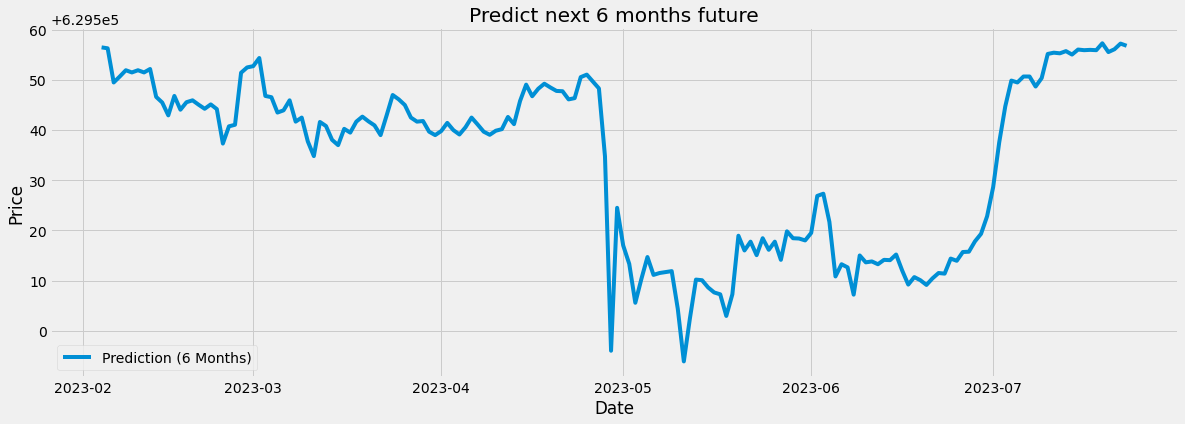

In [46]:
# Vẽ hình
plt.figure(figsize=(18,6))
plt.plot(df_pred_6month['Date'], df_pred_6month['Price'], label='Prediction (6 Months)')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('Predict next 6 months future')
plt.legend()
plt.show()

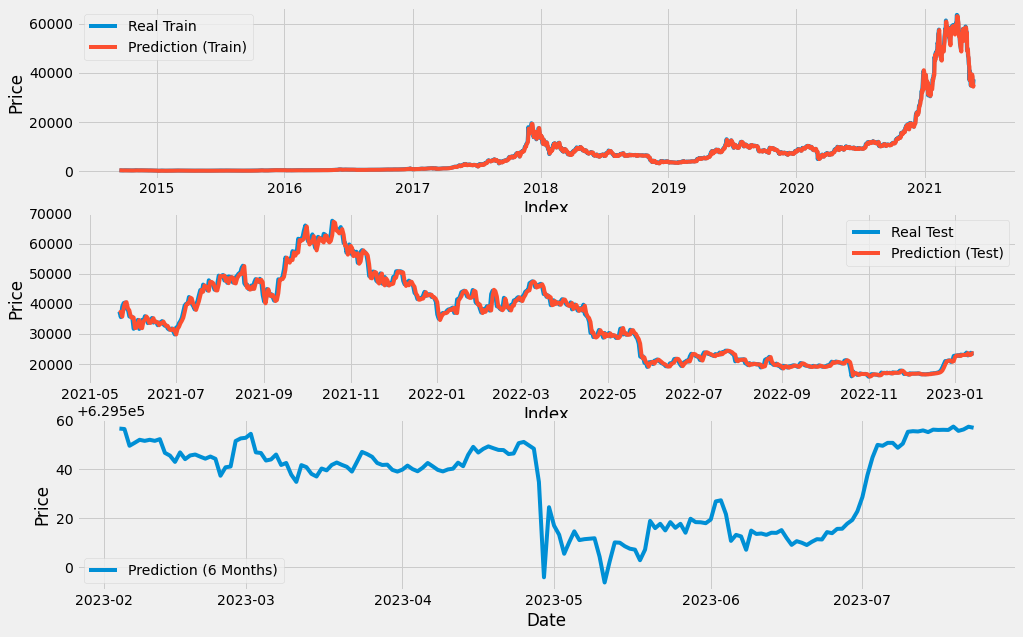

In [45]:
plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
plt.plot(df.index[:len(y_train)], y_train, label='Real Train')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(3,1,2)
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_pred_6month['Date'], df_pred_6month['Price'], label='Prediction (6 Months)')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.show()